## Завантажуємо бібліотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Завантажуємо дані

In [2]:
#Load data
schars = pd.read_csv('simpsons_characters.csv')
sepisodes = pd.read_csv('simpsons_episodes.csv')
slines = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
locations = pd.read_csv('simpsons_locations.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
sepisodes = sepisodes[sepisodes.season != 27] 
sepisodes = sepisodes[sepisodes.season != 28] 

## Підготуємо та дослідимо дані

### Додамо дані про кількість персонажів у епізоді, кількість локацій та кількість слів

In [3]:
sepisodes['num_characters'] = 0
sepisodes['words_count'] = 0
sepisodes['num_locations'] = 0

for id in sepisodes['id']:
    num_characters = len(slines[slines['episode_id'] == id].dropna().character_id.drop_duplicates())
    words_count = slines[slines['episode_id'] == id].dropna().word_count.sum()
    num_locations = len(slines[slines['episode_id'] == id].dropna().location_id.drop_duplicates())
    sepisodes.set_value(sepisodes['id'] == id, 'num_characters', num_characters + 1)
    sepisodes.set_value(sepisodes['id'] == id, 'words_count', words_count + 1)
    sepisodes.set_value(sepisodes['id'] == id, 'num_locations', num_locations + 1)
    
sepisodes[['id', 'num_characters', 'words_count', 'num_locations']].head(5)

,id,num_characters,words_count,num_locations
0,10,41,2522.0,29
1,12,34,2789.0,16
2,14,28,2647.0,19
3,17,29,2765.0,15
4,19,15,2689.0,14


### Подивимось гістограму кількості персонажів у епізоді

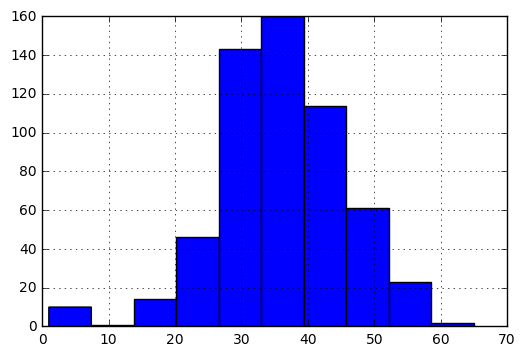

In [4]:
sepisodes['num_characters'].hist()

### Подивимось гістограму кількості слів у епізоді

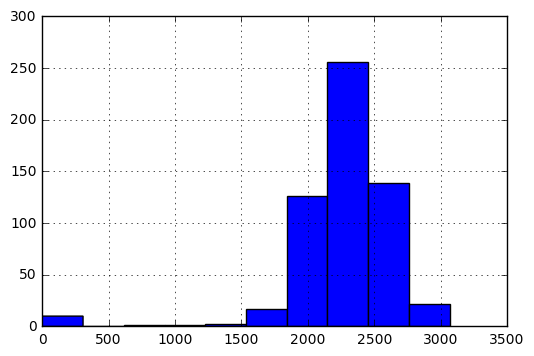

In [5]:
sepisodes['words_count'].hist()

### Подивимось гістограму кількості локацій у епізоді

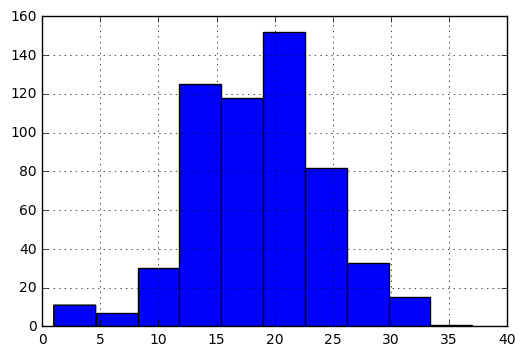

In [6]:
sepisodes['num_locations'].hist()

### Додамо дані про головного героя епізоду, базуючих на кількості сказанних слів

In [7]:
main_characters = np.asarray(slines['raw_character_text'].value_counts().keys()[0:4])

In [8]:
sepisodes['main_character'] = 0

for id in sepisodes['id']:
    main_character = slines[slines['episode_id'] == id].dropna().groupby(['raw_character_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_character) and main_character[0] in main_characters):
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', main_character[0])
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', 'Else')

In [9]:
sepisodes[['id', 'main_character']].head(5)

,id,main_character
0,10,Homer Simpson
1,12,Else
2,14,Bart Simpson
3,17,Else
4,19,Homer Simpson


### Подивимось на розподіл головних героїв у епізодах

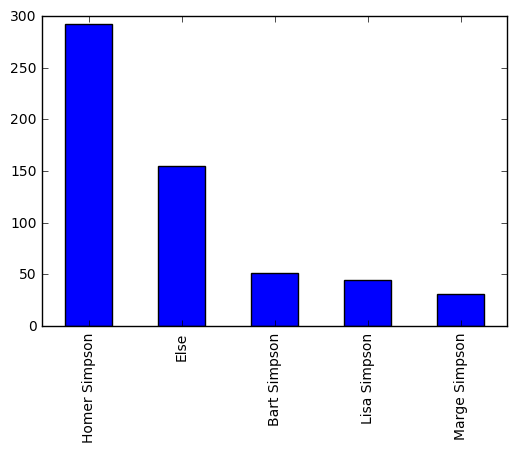

In [10]:
sepisodes['main_character'].value_counts().plot(kind='bar')

### Додамо дані про головну локацію епізоду

In [11]:
main_locations = np.asarray(slines['raw_location_text'].value_counts().keys()[0:4])

In [12]:
sepisodes['main_location'] = 0

for id in sepisodes['id']:
    main_location = slines[slines['episode_id'] == id].dropna().groupby(['raw_location_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_location) and main_location[0] in main_locations):
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', main_location[0])
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', 'Elsewhere')

In [13]:
sepisodes[['id', 'main_location']].head(5)

,id,main_location
0,10,Elsewhere
1,12,Elsewhere
2,14,Elsewhere
3,17,Simpson Home
4,19,Elsewhere


### Подивимось на розподіл головних локацій у епізодах

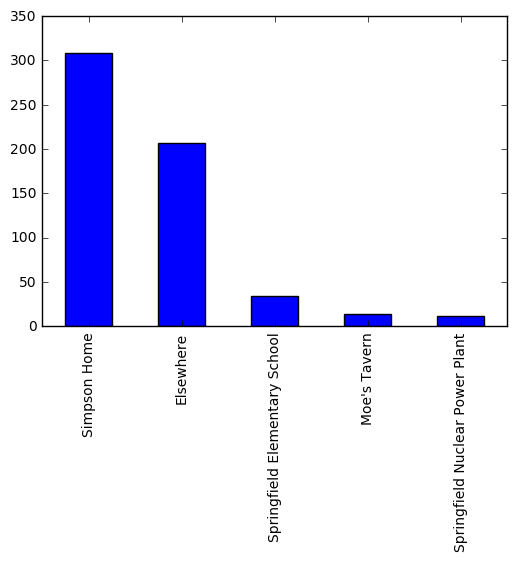

In [14]:
sepisodes['main_location'].value_counts().plot(kind='bar')

## Залежність між ознаками та рейтингом епізоду

/Users/Vera/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


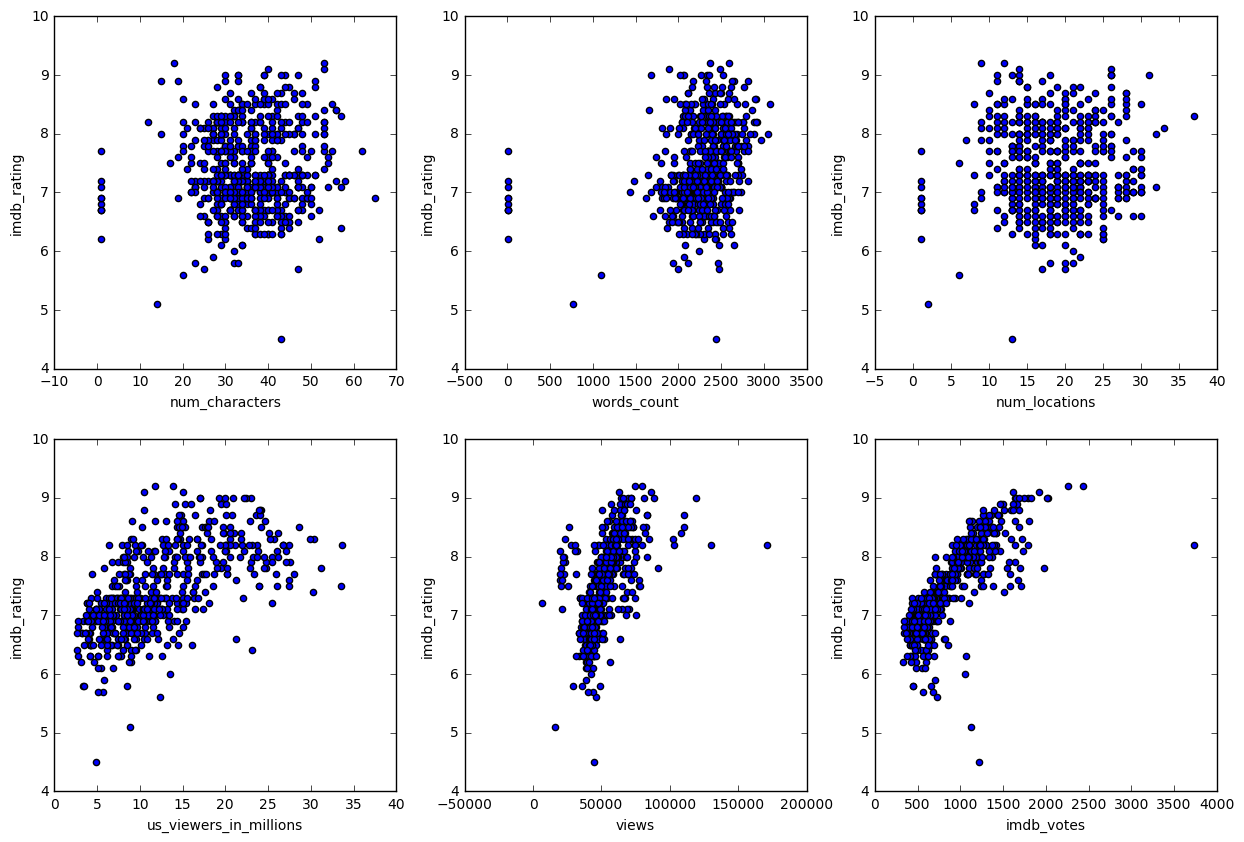

In [15]:
episodes_data = sepisodes[['num_characters', 'words_count', 'num_locations', 'us_viewers_in_millions','views','imdb_votes','imdb_rating']]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(episodes_data.columns[:-1]):
    episodes_data.plot(feature, "imdb_rating", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])

### Подивимось на кореляційну таблицю ознак

In [16]:
sepisodes[['num_characters', 'words_count', 'num_locations', 'main_character', 'main_location','us_viewers_in_millions','views','imdb_votes','imdb_rating']].corr()

,num_characters,words_count,num_locations,us_viewers_in_millions,views,imdb_votes,imdb_rating
num_characters,1.000000,0.363098,0.422305,0.080546,0.122491,0.021944,0.088304
words_count,0.363098,1.000000,0.279054,0.270034,0.137180,0.291181,0.260180
num_locations,0.422305,0.279054,1.000000,0.092154,0.093318,0.019389,0.036510
us_viewers_in_millions,0.080546,0.270034,0.092154,1.000000,0.514562,0.773400,0.614102
views,0.122491,0.137180,0.093318,0.514562,1.000000,0.651462,0.592642
imdb_votes,0.021944,0.291181,0.019389,0.773400,0.651462,1.000000,0.782491
imdb_rating,0.088304,0.260180,0.036510,0.614102,0.592642,0.782491,1.000000


In [17]:
data = sepisodes[['num_characters', 'words_count', 'num_locations', 'main_character', 'main_location','us_viewers_in_millions','views','imdb_votes','imdb_rating']]
data = pd.get_dummies(data, columns=['main_character', 'main_location']).dropna()

### Перетворимо категоріальні дані та подивимось на ознаки для вивчення

In [18]:
data.head()

,num_characters,words_count,num_locations,us_viewers_in_millions,views,imdb_votes,imdb_rating,main_character_Bart Simpson,main_character_Else,main_character_Homer Simpson,main_character_Lisa Simpson,main_character_Marge Simpson,main_location_Elsewhere,main_location_Moe's Tavern,main_location_Simpson Home,main_location_Springfield Elementary School,main_location_Springfield Nuclear Power Plant
0,41,2522.0,29,30.3,50816.0,1511.0,7.4,0,0,1,0,0,1,0,0,0,0
1,34,2789.0,16,30.4,62561.0,1716.0,8.3,0,1,0,0,0,1,0,0,0,0
2,28,2647.0,19,33.6,59575.0,1638.0,8.2,1,0,0,0,0,1,0,0,0,0
3,29,2765.0,15,26.1,64959.0,1457.0,8.1,0,1,0,0,0,0,0,1,0,0
4,15,2689.0,14,25.4,50691.0,1366.0,8.0,0,0,1,0,0,1,0,0,0,0


### Збережемо дані у файл

In [19]:
data.to_csv('data.csv')